In [1]:
import math
import numpy as np
from skimage import feature as skif
import cv2
import os
import glob

#"C:\Users\bhanu\Desktop\gmm\real_videos\real\20230130_160839_AdobeExpress.mp4"

In [2]:
#LBP FEATURES
def lbp_histogram(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = skif.local_binary_pattern(gray_image, P=8, R=1, method='nri_uniform')
    max_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=max_bins, range=(0, max_bins))
    hist_normalized = hist / np.sum(hist)
    return hist_normalized

def get_lbp_hist(video_path):
    cap = cv2.VideoCapture(video_path)
    feature_vectors = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        feature_vector = lbp_histogram(frame)
        feature_vectors.append(feature_vector)

    cap.release()

    # Compute the average feature vector
    avg_feature_vector = np.mean(feature_vectors, axis=0)

    return avg_feature_vector


In [3]:
def create_gmm_background_model(video_path):
    cap = cv2.VideoCapture(video_path)
    bg_sub = cv2.createBackgroundSubtractorMOG2()
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        fg_mask = bg_sub.apply(frame)
    background_model = bg_sub.getBackgroundImage()
    
   
    cap.release()

    return background_model

In [4]:
def apply_2d_fft(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fft = np.fft.fft2(gray)
    fft_shifted = np.fft.fftshift(fft)
    magnitude_spectrum = np.abs(fft_shifted)

    return magnitude_spectrum

def fft_feature(video_path):
    background_model = create_gmm_background_model(video_path)
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        foreground = cv2.absdiff(frame, background_model)
        frames.append(foreground)

    cap.release()
    feature = []
    print(len(frames))
    for frame in frames:
        frequency_feature = apply_2d_fft(frame)
        feature.append(frequency_feature)

    feature_3 = np.mean(feature, axis=(0, 1,2))

    return feature_3



In [25]:
def gmmfeatures(video_path):
    fgP=[]
    bgP=[]
    bgA=[]
    fgA=[]


    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    bg_subtractor = cv2.createBackgroundSubtractorMOG2()
    while cap.isOpened:
        ret, frame = cap.read()


        if not ret:
            break
        fg_mask = bg_subtractor.apply(frame)
        fg_pixels = cv2.countNonZero(fg_mask)
        bg_pixels = fg_mask.size - fg_pixels
        fgP.append(fg_pixels)
        bgP.append(bg_pixels)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


    cap = cv2.VideoCapture(video_path)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    total_area = width * height
    while cap.isOpened:
        ret, frame = cap.read()


        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        face_area = 0
        bg_area = total_area
        for (x, y, w, h) in faces:
            face_area += w * h
            bg_area -= w * h

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        fgA.append(face_area)
        bgA.append(bg_area)

    mt1=[]
    mt2=[]
    for i in range(0,len(fgA)):
        epsilon = 1e-6
        if(fgA[i]!=0):
            mtf=fgP[i]/fgA[i]
        else:
            mtf=epsilon
        mt1.append(mtf)
    for i in range(0,len(bgA)):

        mtb=fgP[i]/bgA[i]
        mt2.append(mtb)
    
    nm=0
    cmd=0
    dm=0
    motion_features = []
    mEntropyList=[]
    for i in range(len(mt1)):
        epsilon = 1e-6
        nm=(mt1[i]-mt2[i])**2
        dm=(mt1[i]+mt2[i])
        if dm != 0:
            cmd += (nm / dm)
        else:
            cmd += epsilon
        pi=fgP[i]/(fgP[i]+bgP[i])
        u=1/(width*height)
        if(pi>=1):
            pi=min(pi,1-u)
        elif(pi==0):
            pi=max(pi,u)

        me=-pi*math.log(pi)-(1-pi)*math.log(1-pi)
        mEntropyList.append(me)
    cmd=cmd/total_frames
    print(total_frames)
    mEntropysum=0
    avgmEntropy=0
    for i in range(len(mEntropyList)):
        mEntropysum+=mEntropyList[i]
    avgmEntropy=mEntropysum/len(mEntropyList)
    return [cmd,avgmEntropy]


In [26]:
def concatenate(video_path):
    feature_vector_1=get_lbp_hist(video_path)
    feature_vector_1=np.array(feature_vector_1)
    feature_vector_2=gmmfeatures(video_path)
    feature_vector_2=np.array(feature_vector_2)
    
    feature_vector_3=fft_feature(video_path)
    feature_vector_3=np.array(feature_vector_3)

    
    feature_vector_3 = np.reshape(feature_vector_3, (1,)) 
    concatenated_vector = np.concatenate((feature_vector_1, feature_vector_2, feature_vector_3))
    return concatenated_vector


In [12]:
#cc=concatenate(r"C:\Users\bhanu\Desktop\gmm\real_videos\real\20230130_160839_AdobeExpress.mp4")

In [13]:

folder_path = r"C:\Users\bhanu\Desktop\gmm\real" # Replace with the actual path to your folder
real_video_paths=[]
video_extensions = ['.mp4', '.mov']  # Add more extensions if needed
for extension in video_extensions:
    search_pattern = os.path.join(folder_path, f'*{extension}')
    real_video_paths.extend(glob.glob(search_pattern))
print(len(real_video_paths))

70


In [27]:

folder_path = r"C:\Users\bhanu\Desktop\gmm\test_sample" # Replace with the actual path to your folder
fake_video_paths=[]
video_extensions = ['.mp4', '.mov']  # Add more extensions if needed
for extension in video_extensions:
    search_pattern = os.path.join(folder_path, f'*{extension}')
    fake_video_paths.extend(glob.glob(search_pattern))
print(len(fake_video_paths))

126


In [15]:
#real videos feature vectors
real_access=[]
for video_path in real_video_paths:
    concatenated_features=concatenate(video_path)
    real_access.append(concatenated_features)
print(len(real_access))

300
300
300
300
300
300
301
301
301
301
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
301
301
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
301
301
239
239
242
242
301
301
301
301
217
217
269
269
246
246
301
301
290
290
277
277
301
301
283
283
244
244
270
270
237
237
301
301
301
301
234
234
246
246
234
234
246
246
301
301
243
243
301
301
276
276
234
234
250
250
234
234
222
222
229
229
238
238
259
259
301
301
274
274
70


In [28]:
#real videos feature vectors
fake_access=[]
for video_path in fake_video_paths:
    concatenated_features=concatenate(video_path)
    fake_access.append(concatenated_features)
print(len(fake_access))

300
300
300
300
276
276
300
300
300
300
231
231
300
300
300
300
230
230
300
300
300
300
220
220
300
300
300
300
222
222
300
300
300
300
223
223
300
300
300
300
212
212
300
300
301
301
192
192
301
301
301
301
230
230
301
301
301
301
244
244
301
301
301
301
245
245
301
301
301
301
253
253
301
301
301
301
235
235
300
299
301
301
226
226
301
301
301
301
232
232
301
301
301
301
215
215
301
301
301
301
227
227
262
262
301
301
228
228
301
301
301
301
229
229
301
301
301
301
229
229
300
300
301
301
227
227
311
311
301
300
228
228
298
298
301
301
230
230
301
301
302
302
214
214
301
301
301
301
205
205
300
300
300
300
204
204
301
301
301
301
201
201
301
301
301
301
201
201
301
301
300
300
223
223
301
301
301
301
212
212
301
301
301
301
200
200
300
300
301
301
191
191
300
300
301
301
203
203
301
301
301
301
191
191
301
301
301
301
196
196
300
300
300
300
208
208
301
301
301
301
213
213
301
301
301
301
207
207
301
301
301
301
211
211
301
301
301
301
213
213
301
301
301
301
235
235
301
301
301
301


In [29]:
all_feature_vector=[]
all_feature_vector=real_access+fake_access
print(len(all_feature_vector))
labels = np.array([0] * len(real_access) + [1] * len(fake_access))
print(len(labels))


196
196


In [95]:
for i in all_feature_vector:
    print(len(i))

62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62


In [32]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from hmmlearn import hmm

In [57]:
X_train, X_test, y_train, y_test = train_test_split(all_feature_vector, labels, test_size=0.4, random_state=4)
hmm_model = hmm.GaussianHMM()

hmm_model.fit(X_train) 
hmm_features_train = hmm_model.predict_proba(X_train)
hmm_features_test = hmm_model.predict_proba(X_test)
combined_features_train = np.concatenate((X_train, hmm_features_train), axis=1)
combined_features_test = np.concatenate((X_test, hmm_features_test), axis=1)
svm_classifier = svm.SVC()  
svm_classifier.fit(combined_features_train, y_train)
y_pred = svm_classifier.predict(combined_features_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("precision:",precision)
print("recall",recall)
print("f1:",f1)


Accuracy: 0.810126582278481
precision: 0.803030303030303
recall 0.9636363636363636
f1: 0.8760330578512396


In [58]:
from sklearn.metrics import confusion_matrix



# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[11 13]
 [ 2 53]]


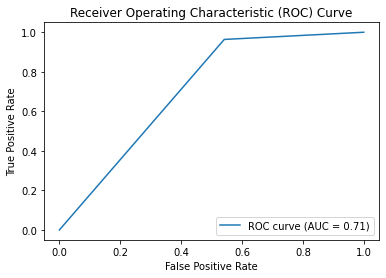

In [59]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Plotting the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [62]:
import joblib
joblib.dump(svm_classifier, 'model.pkl')

model = joblib.load(r"C:\Users\bhanu\Desktop\gmm\model.pkl")

In [114]:
new_access=[]
video_path=r"C:\Users\bhanu\Desktop\gmm\attack\attack_client034_android_SD_ipad_video_scene01.mp4"  #new fake video from mfsu mfsd data

concatenated_features=concatenate(video_path)
new_access.append(concatenated_features)


300
300


In [115]:
import numpy as np

# Convert new_access list to numpy array
new_access = np.array(new_access)

additional_feature = np.zeros((new_access.shape[0], 1))

new_access_with_additional_feature = np.concatenate((new_access, additional_feature), axis=1)



# Perform prediction
predicted_class = model.predict(new_access_with_additional_feature)
print(predicted_class)


[1]


In [63]:
folder_path = r"C:\Users\bhanu\Desktop\gmm\fake_videos\fake" # Replace with the actual path to your folder
new_fake_video_paths=[]
video_extensions = ['.mp4', '.mov']  # Add more extensions if needed
for extension in video_extensions:
    search_pattern = os.path.join(folder_path, f'*{extension}')
    new_fake_video_paths.extend(glob.glob(search_pattern))
print(len(new_fake_video_paths))

27


In [64]:
folder_path = r"C:\Users\bhanu\Desktop\gmm\real_videos\real" # Replace with the actual path to your folder
new_real_video_paths=[]
video_extensions = ['.mp4', '.mov']  # Add more extensions if needed
for extension in video_extensions:
    search_pattern = os.path.join(folder_path, f'*{extension}')
    new_real_video_paths.extend(glob.glob(search_pattern))
print(len(new_real_video_paths))

10


In [65]:
#real videos feature vectors
new_real_access=[]
for video_path in new_real_video_paths:
    concatenated_features=concatenate(video_path)
    new_real_access.append(concatenated_features)
print(len(new_real_access))

355
355
314
314
204
204
164
164
182
182
169
169
170
170
193
193
187
187
375
375
10


In [66]:
new_fake_access=[]
for video_path in new_fake_video_paths:
    concatenated_features=concatenate(video_path)
    new_fake_access.append(concatenated_features)
print(len(new_fake_access))

309
309
314
314
326
326
303
303
306
306
252
252
231
231
358
358
306
306
415
415
237
237
468
468
240
240
237
237
232
232
231
231
238
238
469
469
445
445
486
486
482
482
550
550
428
428
461
461
468
468
474
474
473
473
27


In [92]:
all_new_feature_vector=[]
all_new_feature_vector=new_real_access+new_fake_access
print(len(all_new_feature_vector))
new_labels = np.array([0] * len(new_real_access) + [1] * len(new_fake_access))
print(len(new_labels))







37
37


In [93]:
hmm_model = hmm.GaussianHMM()

hmm_model.fit(X_train) 
hmm_features_train = hmm_model.predict_proba(all_feature_vector)
hmm_features_test = hmm_model.predict_proba(all_new_feature_vector)
svm_classifier = svm.SVC()  
svm_classifier.fit(hmm_features_train, labels)
y_pred = svm_classifier.predict(hmm_features_test)

accuracy = accuracy_score(new_labels, y_pred)
precision = precision_score(new_labels, y_pred)
recall = recall_score(new_labels, y_pred)
f1 = f1_score(new_labels, y_pred)

print("Accuracy:", accuracy)
print("precision:",precision)
print("recall",recall)
print("f1:",f1)


Accuracy: 0.7297297297297297
precision: 0.7297297297297297
recall 1.0
f1: 0.8437499999999999
